In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import plotly.graph_objects as go

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = map(int, file.readline().strip().split(' '))
    verts = [list(map(float, file.readline().strip().split(' '))) for i_vert in range(n_verts)]
    faces = [list(map(int, file.readline().strip().split(' ')[1:])) for i_face in range(n_faces)]
    return verts, faces

with open('/content/drive/MyDrive/ModelNet10/bed/bed_0526.off', 'r') as f:
    verts, faces = read_off(f)

verts_np = np.array(verts)
faces_np = np.array(faces)

# Create the mesh

x = verts_np[:,0]
y = verts_np[:,1]
z = verts_np[:,2]

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   i=faces_np[:,0],
                   j=faces_np[:,1],
                   k=faces_np[:,2],
                   color='lightpink', opacity=0.50)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()


In [ ]:
with open('/content/drive/MyDrive/ModelNet10/monitor/monitor_0477.off', 'r') as f:
    verts, faces = read_off(f)

verts_np = np.array(verts)
faces_np = np.array(faces)

# Create the mesh

x = verts_np[:,0]
y = verts_np[:,1]
z = verts_np[:,2]

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   i=faces_np[:,0],
                   j=faces_np[:,1],
                   k=faces_np[:,2],
                   color='lightpink', opacity=0.50)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [ ]:
with open('/content/drive/MyDrive/ModelNet10/night_stand/night_stand_0215.off', 'r') as f:
    verts, faces = read_off(f)

verts_np = np.array(verts)
faces_np = np.array(faces)

# Create the mesh

x = verts_np[:,0]
y = verts_np[:,1]
z = verts_np[:,2]

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   i=faces_np[:,0],
                   j=faces_np[:,1],
                   k=faces_np[:,2],
                   color='lightpink', opacity=0.50)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [2]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.6/681.6 kB 23.9 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import trimesh

In [4]:
def off_to_voxel(file, size=16):
    mesh = trimesh.load_mesh(file)
    voxel_grid = mesh.voxelized(pitch=size)

    # Ensure that the voxel grid is of shape (size, size, size)
    resized_voxel = np.zeros((size, size, size))
    voxel_shape = voxel_grid.matrix.shape
    min_dim1 = min(voxel_shape[0], size)
    min_dim2 = min(voxel_shape[1], size)
    min_dim3 = min(voxel_shape[2], size)

    resized_voxel[:min_dim1, :min_dim2, :min_dim3] = voxel_grid.matrix[:min_dim1, :min_dim2, :min_dim3]

    return resized_voxel[..., np.newaxis]  # add an extra dimension for channels


In [5]:
def load_dataset(dataset_path, classes, size=16):
    x = []
    y = []
    for class_index, class_name in enumerate(classes):
        print(f"Loading files from class: {class_name}")
        path = os.path.join(dataset_path, class_name)
        for filename in os.listdir(path):
            voxel = off_to_voxel(os.path.join(path, filename), size=size)
            x.append(voxel)
            y.append(class_index)
    return np.stack(x), np.array(y)  # use np.stack instead of np.array for x


In [6]:
classes = ['bed', 'monitor', 'night_stand']
x, y = load_dataset("/content/drive/MyDrive/ModelNet10", classes)
y = to_categorical(y, num_classes=len(classes))


Loading files from class: bed
Loading files from class: monitor
Loading files from class: night_stand


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


In [8]:
model = Sequential()

# 입력 데이터 크기: (16, 16, 16, 1)
# 필터 개수: 64
# 필터 크기: (3, 3, 3)
# 활성화 함수: ReLU
# 출력 데이터 크기: (14, 14, 14, 64)
model.add(Conv3D(64, (3, 3, 3), activation='relu', input_shape=(16, 16, 16, 1)))

# 풀링 영역 크기: (2, 2, 2)
# 출력 데이터 크기: (7, 7, 7, 64)
model.add(MaxPool3D(pool_size=(2, 2, 2)))

# 필터 개수: 128
# 필터 크기: (3, 3, 3)
# 활성화 함수: ReLU
# 출력 데이터 크기: (5, 5, 5, 128)
model.add(Conv3D(128, (3, 3, 3), activation='relu'))

# 풀링 영역 크기: (2, 2, 2)
# 출력 데이터 크기: (2, 2, 2, 128)
model.add(MaxPool3D(pool_size=(2, 2, 2)))

# 3D 데이터를 1D로 평탄화
# 출력 데이터 크기: 512
model.add(Flatten())

# 은닉층 노드 개수: 512
# 활성화 함수: ReLU
# 출력 데이터 크기: 512
model.add(Dense(512, activation='relu'))


# 출력 노드 개수: 클래스 개수
# 활성화 함수: 소프트맥스
# 출력 데이터 크기: 클래스 개수
model.add(Dense(len(classes), activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [10]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
2/2 [==============================] - 12s 383ms/step - loss: 1.0793 - accuracy: 0.3778 - val_loss: 0.8767 - val_accuracy: 0.7500
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 0.9761 - accuracy: 0.6444 - val_loss: 0.6918 - val_accuracy: 0.7500
Epoch 3/20
2/2 [==============================] - 0s 54ms/step - loss: 0.8448 - accuracy: 0.7111 - val_loss: 0.5678 - val_accuracy: 0.7500
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.7225 - accuracy: 0.7333 - val_loss: 0.4692 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 0s 54ms/step - loss: 0.6165 - accuracy: 0.7333 - val_loss: 0.3735 - val_accuracy: 0.7500
Epoch 6/20
2/2 [==============================] - 0s 37ms/step - loss: 0.5335 - accuracy: 0.7333 - val_loss: 0.3102 - val_accuracy: 0.7500
Epoch 7/20
2/2 [==============================] - 0s 36ms/step - loss: 0.4610 - accuracy: 0.7556 - val_loss: 0.2506 - val_accuracy: 0.9167
Epoch 8/20
2/2 [=========

In [11]:
def predict_class(file_path, model, size=16):
    # Voxel 변환을 수행
    voxel = off_to_voxel(file_path, size=size)

    # Voxel 데이터를 (1, size, size, size, 1) 형태로 변환합니다.
    # 이렇게 해야지 모델이 단일 예측을 수행할 수 있습니다.
    voxel = np.expand_dims(voxel, axis=0)

    # 클래스 예측 수행
    prediction = model.predict(voxel)

    # 예측된 클래스 인덱스를 얻습니다.
    predicted_class_index = np.argmax(prediction, axis=1)

    return classes[predicted_class_index[0]]  # 예측된 클래스 이름 반환

# 예측을 수행하고 결과를 출력
file_path = "/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off"
predicted_class = predict_class(file_path, model)
print(f"The predicted class for the object in {file_path} is: {predicted_class}")


1/1 [==============================] - 0s 126ms/step
The predicted class for the object in /content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off is: night_stand


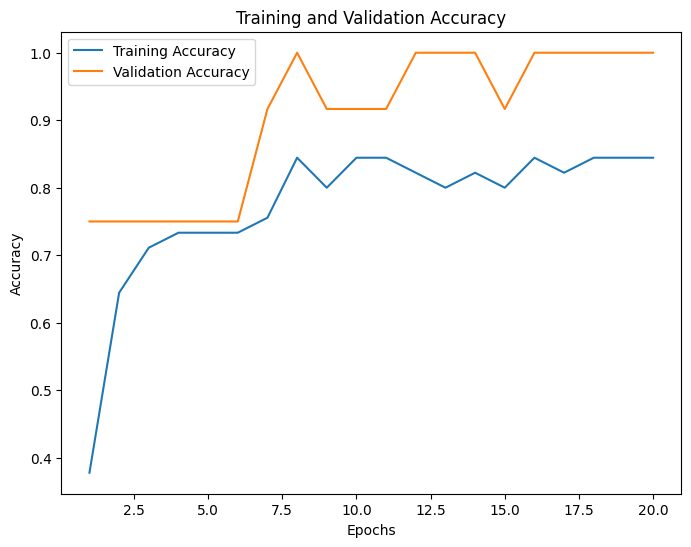

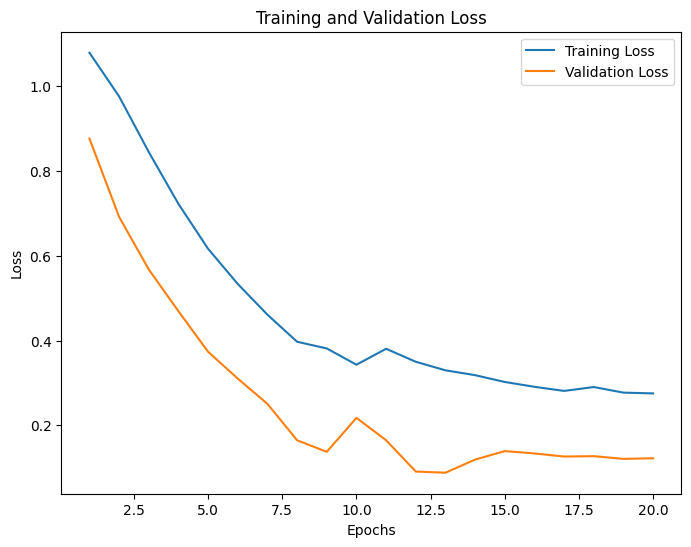

In [12]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


train_loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 새로운 데이터에 대한 실험

In [17]:
with open('/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', 'r') as f:
    verts, faces = read_off(f)

verts_np = np.array(verts)
faces_np = np.array(faces)

# Create the mesh

x = verts_np[:,0]
y = verts_np[:,1]
z = verts_np[:,2]

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z,
                   i=faces_np[:,0],
                   j=faces_np[:,1],
                   k=faces_np[:,2],
                   color='lightpink', opacity=0.50)])

fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [18]:
def predict_class(file_path, model, size=16):
    # Voxel 변환을 수행
    voxel = off_to_voxel(file_path, size=size)

    # Voxel 데이터를 (1, size, size, size, 1) 형태로 변환합니다.
    # 이렇게 해야지 모델이 단일 예측을 수행할 수 있습니다.
    voxel = np.expand_dims(voxel, axis=0)

    # 클래스 예측 수행
    prediction = model.predict(voxel)

    # 예측된 클래스 인덱스를 얻습니다.
    predicted_class_index = np.argmax(prediction, axis=1)

    return classes[predicted_class_index[0]]  # 예측된 클래스 이름 반환

# 예측을 수행하고 결과를 출력
file_path = "/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off"
predicted_class = predict_class(file_path, model)
print(f"\n오른쪽과 같은 경로 {file_path} 의 class 결과는: {predicted_class}")


1/1 [==============================] - 0s 23ms/step

오른쪽과 같은 경로 /content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off 의 class 결과는: night_stand


In [19]:
from tensorflow.keras.models import Model
import numpy as np

def get_dense_output(model, file_path, size=16):
    # 이전 레이어까지 새로운 모델을 정의합니다. 여기서는 Flatten() 이후의 레이어까지 포함시킵니다.
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)

    # Voxel 변환을 수행
    voxel = off_to_voxel(file_path, size=size)

    # Voxel 데이터를 (1, size, size, size, 1) 형태로 변환합니다.
    # 이렇게 해야지 모델이 단일 예측을 수행할 수 있습니다.
    voxel = np.expand_dims(voxel, axis=0)

    # 새로운 모델을 사용해 Dense 레이어의 출력을 얻습니다.
    dense_output = intermediate_model.predict(voxel)

    return dense_output

def compare_outputs2(model, file_path1, file_path2):
    # 두 파일에 대한 Dense 레이어의 출력을 얻습니다.
    dense_output1 = get_dense_output(model, file_path1)
    dense_output2 = get_dense_output(model, file_path2)
    print("결과1: ",  dense_output1)
    print("결과2: ",  dense_output2)
    # 두 출력의 유클리드 거리를 계산합니다.
    euclidean_distance = np.linalg.norm(dense_output1 - dense_output2)

    print("유클리드 거리: ",euclidean_distance)


def compare_outputs(model, file_path1, file_path2):
    # 두 파일에 대한 Dense 레이어의 출력을 얻습니다.
    dense_output1 = get_dense_output(model, file_path1)
    dense_output2 = get_dense_output(model, file_path2)
    # 두 출력의 유클리드 거리를 계산합니다.
    euclidean_distance = np.linalg.norm(dense_output1 - dense_output2)

    print("유클리드 거리: ",euclidean_distance)



In [20]:
compare_outputs2(model, '/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', '/content/drive/MyDrive/ModelNet10/unseen/bed_0015.off')


1/1 [==============================] - 0s 105ms/step
결과1:  [[1.7873316  1.1167217  0.28404555 1.4919126  0.52554667 0.
  0.7223223  0.65489215 0.7787968  0.91664034 1.6321968  0.20505613
  0.16631114 1.299316   1.8772669  0.83280593 0.25313917 0.3555549
  0.2911324  0.9471451  0.13961792 0.23711114 1.0742897  0.2618344
  0.         0.         0.5771811  0.         0.         0.9580682
  0.         0.83115256 0.83726907 0.         0.         0.43965915
  0.         0.         0.         0.5950246  0.85388774 1.7415578
  0.7364242  0.         1.0851437  0.33568087 0.         1.1006335
  0.6458086  0.25970274 1.7178015  0.         0.         0.28832504
  0.         1.1469011  0.         0.7034025  0.         0.7512324
  0.         0.69422895 1.6069162  0.33265403 0.749504   0.39140478
  0.4434331  0.00469875 1.6893604  0.0736132  1.0890869  0.
  0.         0.9894816  0.36475036 2.355331   0.         0.44402117
  1.2911019  0.         0.60978323 0.07237726 0.27008125 0.
  0.         0.7449

In [21]:
compare_outputs(model, '/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', '/content/drive/MyDrive/ModelNet10/unseen/bed_0015.off')
compare_outputs(model, '/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', '/content/drive/MyDrive/ModelNet10/unseen/night_stand_0013.off')
compare_outputs(model, '/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', '/content/drive/MyDrive/ModelNet10/unseen/sofa_0006.off')


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 62ms/step


유클리드 거리:  19.825138
1/1 [==============================] - 0s 64ms/step
유클리드 거리:  20.94897
1/1 [==============================] - 0s 59ms/step
유클리드 거리:  13.127665


In [22]:
compare_outputs(model, '/content/drive/MyDrive/ModelNet10/unseen/dresser_0013.off', '/content/drive/MyDrive/ModelNet10/unseen/monitor_0006.off')

1/1 [==============================] - 0s 96ms/step
유클리드 거리:  16.869133
